# Free energy landscapes and clustering with Gaussian mixture models

## 1. Reading the data

In [1]:
import numpy as np
import GMM_FE

data = np.loadtxt('data/CaM_PCA_CA_contacts_REST.txt')


## 2. Constructing the object and setting parameters
Create a free energy and clustering object. In principle, *data*, minimum number of components, *min_n_components*, and maximum number of components, *max_n_components* need to be specified. If *max_n_components* is not specified, the free energy estimation and clustering will be done using *min_n_components* components. The settings of necessary parameters will be printed below.

In [12]:
gmm_FE = GMM_FE.FreeEnergy(data, min_n_components=10, max_n_components=34, temperature=300.0, 
                            n_iterations=3, n_grids=30)

*----------------Gaussian mixture model free energy estimator----------------*
   n_splits = 3
   shuffle_data = False
   n_iterations = 3
   n_grids = 30
   covergence_tol = 0.0001
   stack_landscapes = False
   axes limits (x_lim) = [[-4.8644411168558515, 10.83157794323054], [-6.875103988258936, 8.627237475799573]]
   temperature = 300.0
   min_n_components = 10
   max_n_components = 34
*----------------------------------------------------------------------------*


## 3. Estimating free energy landscapes

Calling the function *landscape()* will estimate the density and free energy landscape given data. The axes limits of the landscape are printed above. The density estimation is performed with Gaussian mixture models (GMM) and *K*-fold cross-validation. The number of folds in the cross-validation is set with the variable *n_splits*. This is done in two ways depending on if *mixtures_of_landscapes* is set to True or False.
<br>
> **If *mixtures_of_landscapes* is set to False**:
> When *mixtures_of_landscaps* is False, cross-validation will be used to pick the "best" number of GMM components based on the highest log-likelihood of the validation datasets. The final landscape will then be estimated using the full dataset with the "best" number of components.
<br>
**If *mixtures_of_landscapes* is set to True**:
> When *mixtures_of_landscaps* is True, all density models obtained with the training set will be stored. The final density model will be the weighted average of all models. 
> <br>
> <br>
> **Other possibilities**:
> + Trying different setups of training GMMs/mixture of landscapes: 
> > 1. the dataset is split into a training and validation set. All GMMs are trained on training sets. After training, the models are weighted together using the validation dataset. (mixtures_of_landscapes.py). 
> > 2. Simultaneous model weighting and GMM fitting with modified EM-algorithm (ensemble_of_GMMs.py). 
> + Now it seems like ensemble of GMMs works better than the original GMM-CV, when comparing to a disjoint test dataset.
> + We would maybe like to integrate over number of components in a smarter way - MCMC or VI?

**This returns:**
1. *coords*: The coordinates of the grid that is used for visualization.
2. *FE_landscape*: The estimated free energy of each grid point.
3. *FE_points*: The estimated free energy of each point in *data*.

In [13]:
coords, FE_landscape, FE_points = gmm_FE.landscape()
print('Test set log-likelihood: '+str(gmm_FE.test_set_loglikelihood))

Estimating density with GMM.
# Components = 10
# Components = 11
# Components = 12
# Components = 13
# Components = 14
# Components = 15
# Components = 16
# Components = 17
# Components = 18
# Components = 19
# Components = 20
# Components = 21
# Components = 22
# Components = 23
# Components = 24
# Components = 25
# Components = 26
# Components = 27
# Components = 28
# Components = 29
# Components = 30
# Components = 31
# Components = 32
# Components = 33
# Components = 34
Estimating final density with 26 components.
Evaluating density in landscape
Density grid shape: (30, 30)
Test set log-likelihood: None


## 4. Visualizing the free energy landscape
To visualize the estimated free energy landscape, we call the *visualize* function. To visualize with the standard parameter settings, it is just to run 
<br>
> **gmm_FE.visualize()**

<br> However, you might want to change some of the parameters. 
<br><br>
**The following parameters can be changed:**
1. *title*: The title of the figure
2. *fontsize*: Title fontsize, other labels are changed according to this
3. *savefig*: True/False (whether to save a .png and .eps figure)
4. *xlabel*: The x-label
5. *ylabel*: The y-label
6. *vmax*: Colormap max cutoff value.
7. *n_contour_levels*: Determines the number and positions of the contour lines / regions in contourf.
8. *show_data*: True/False (whether to scatter-plot the original data and/or clustering)

AttributeError: 'GaussianMixture' object has no attribute 'model_weights_'

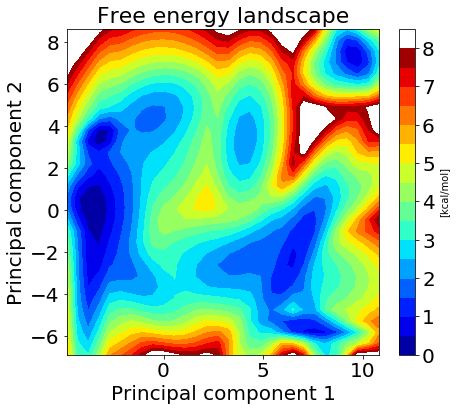

In [14]:
gmm_FE.visualize(savefig=True,vmax=8, n_contour_levels=18, xlabel='Principal component 1', ylabel='Principal component 2',show_data=False)
print('Model weights: '+str(gmm_FE.density_est_.model_weights_))

## 5. Cluster points at free energy minima
Clustering the free energy landscape can be done with 
<br> 
> **gmm_FE.cluster(data,FE_points)**

<br>Recall that *FE_points* is an array with the estimated free energy of each point in *data*. To make the clustering slightly more robust, we can do it over the grid that we use for visualization. The grid coordinates are kept in *coords*. In such case, we also need to parse *data* as a third argument to return the cluster labels and cluster center indices of the *data* points. 
<br> <br>
**This returns:**
1. *labels*: The cluster label/index of each point, denoting which cluster the point belongs to. If zero, the point is a transition point, otherwise it belongs to some intermediate state.
2. *cluster_centers*: Contains the indices corresponding to the point of each cluster that has the smallest free energy.
<br>

Note: Does not support mixtures of GMMs yet.

In [15]:
labels, cluster_centers = gmm_FE.cluster(coords,FE_points,data)

Clustering free energy landscape...
Computing Hessians.
Constructing connected components.
# Graph connections: 126.0
Clustering data points.
Done clustering.


## 6. Visualize free energy landscape with identified clusters

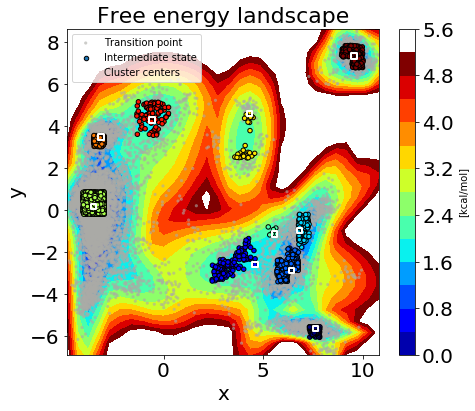

In [16]:
# Visualize free energy landscape with cluster labels
gmm_FE.visualize(savefig=True,vmax=5)